/tmp/ipykernel_227/4031091606.py:152: RuntimeWarning: invalid value encountered in sqrt
  return (AA(x)**0.5)


/tmp/ipykernel_227/4031091606.py:152: RuntimeWarning: invalid value encountered in sqrt
  return (AA(x)**0.5)


/tmp/ipykernel_227/4031091606.py:152: RuntimeWarning: invalid value encountered in sqrt
  return (AA(x)**0.5)


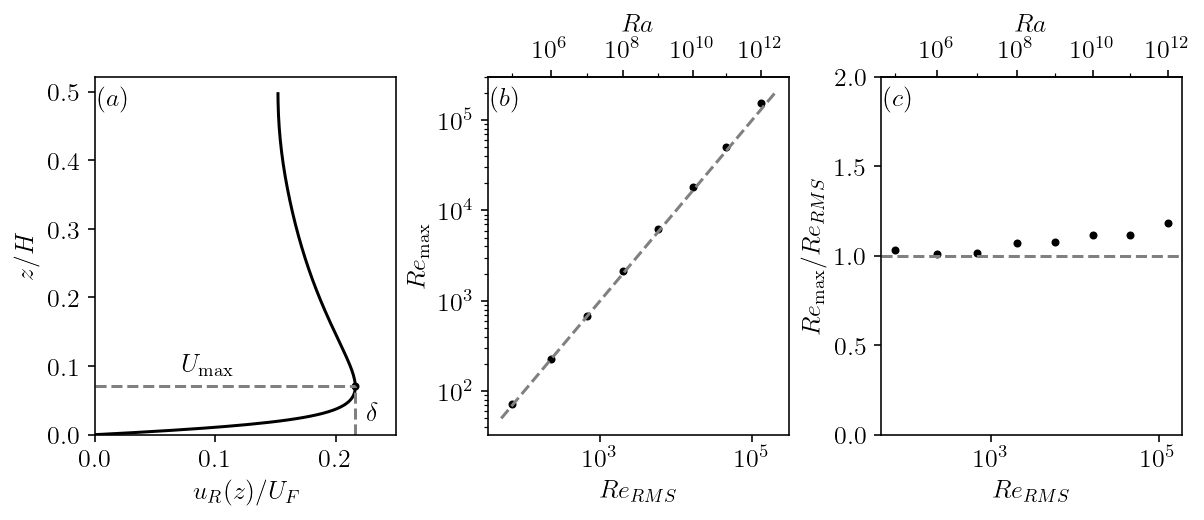

In [4]:
import os
import numpy as np
import scipy.integrate as intg
import scipy.interpolate as intp
import scipy.optimize as sopt
import h5py
import matplotlib.pyplot as pl
from matplotlib.legend_handler import HandlerTuple
from matplotlib.colors import to_rgba
from matplotlib.ticker import AutoMinorLocator

from matplotlib import rc
rc('font',**{'family':'STIXGeneral','serif':['stix'],'size':13})
rc('text', usetex=True)

###################################################################################################

def CF2RE(Cf,kappa=0.41,B=5):

    Aa = (2/Cf)**0.5
    Kk = kappa*(Aa-B)

    return(2*Aa*np.exp(Kk))

def RE2CF(Re,kappa=0.41,B=5,iter=1E4,residual=1E-8,verbose=False):

    Nn = int(np.log10(iter))+1

    # Initial guess
    Cf = 0.060*Re**(-0.25)

    for i in range(int(iter)):
        Aa = (2/Cf)**0.5
        Ik = 1/kappa
        Nr = (Ik*np.log(0.5*Re/Aa)) + B - Aa
        Dr = 0.25*Aa*((Ik*Aa) + (Aa*Aa))
        Cc = Cf - Nr/Dr
        L2 = (np.mean((Cc-Cf)**2))**0.5
        Cf = Cc 
        if verbose: print('Iteration {:{Nn}d}, Residual = {}'.format(i,L2,Nn=int(np.log10(iter))+1))
        if (L2<residual): break
        return(Cf)

###################################################################################################

fig,axs = pl.subplots(1,3,figsize=(8.25,3.5),constrained_layout=True)

###################################################################################################

stafield = h5py.File('../raw_data/RBP/Ra1E+07_Pr1E+00/stafield_master.h5','r')

Ra = stafield['Rayleigh Number'][0]
Pr = stafield['Prandtl Number'][0]

nueff = (Pr/Ra)**0.5

xm    = stafield['xm'][:]

avg_t = stafield['temp_m1'][0]

vy_m2 = stafield['vy_m2'][:]/avg_t
vy_m2 = 0.5*(vy_m2 + np.flip(vy_m2))

vz_m2 = stafield['vz_m2'][:]/avg_t
vz_m2 = 0.5*(vz_m2 + np.flip(vz_m2))

vh_m2 = vy_m2 + vz_m2
vh_m1 = vh_m2**0.5
kk_mx = np.argmax(vh_m1)
bl_mx = xm[kk_mx]
vh_mx = vh_m1[kk_mx]
Re_hl = vh_mx/nueff
Redel = Re_hl*bl_mx

vh_ex = np.pad(vh_m1,(1,1),"constant",constant_values=0)
xm_ex = np.pad(xm,(1,1),"constant",constant_values=(0,1))

vh_xx = np.gradient(vh_ex,xm_ex,edge_order=2)
vh_wl = vh_xx[0]
u_tau = (nueff*vh_wl)**0.5

xm_pl = xm[xm<=0.5]*u_tau/nueff
vh_pl = vh_m1[xm<=0.5]/u_tau

diagf = xm_pl * np.gradient(vh_pl,xm_pl)

axs[0].plot(vh_m1[xm<=0.5],xm[xm<=0.5],color='k')
axs[0].plot(np.max(vh_m1),xm[np.argmax(vh_m1)],marker='.',color='k')
axs[0].plot([np.max(vh_m1),np.max(vh_m1)],[0,xm[np.argmax(vh_m1)]],linestyle='--',color='gray')
axs[0].plot([0,np.max(vh_m1)],[xm[np.argmax(vh_m1)],xm[np.argmax(vh_m1)]],linestyle='--',color='gray')
axs[0].text(np.max(vh_m1)/3,xm[np.argmax(vh_m1)]+0.02,r'$U_{\mathrm{max}}$')
axs[0].text(np.max(vh_m1)+0.01,xm[np.argmax(vh_m1)]-0.05,r'$\delta$')

###################################################################################################

BoxCases = [
    [1E5,1],
    [1E6,1],
    [1E7,1],
    [1E8,1],
    [1E9,1],
    [1E10,1],
    [1E11,1],
    [1E12,1]
]

BoxData = h5py.File('../processed_data/RBP.h5','r')

Ra_list = []
Re_list = []

for BoxCase in BoxCases:

    Ra = BoxCase[0]
    Pr = BoxCase[1]

    if (Ra<1E10): 
        c  = 'k'
        Ga = 16/3
    if ((Ra==1E10) or (Ra==1E11)): 
        c  = 'darkorange'
        Ga = 4
    if (Ra==1E12): 
        c  = 'm'
        Ga = 2

    IxBox = np.intersect1d(np.argwhere(BoxData['Rayleigh'][()]==Ra),np.argwhere(BoxData['Prandtl'][()]==Pr))

    Nu_st = BoxData['Nusselt (stafield)'][IxBox]
    Re_st = BoxData['RMS Reynolds (stafield)'][IxBox]
    Rt_st = BoxData['RMS Friction Reynolds (stafield)'][IxBox]
    Re_mx = BoxData['RMS Horizontal Reynolds (stafield)'][IxBox]
    Bl_mx = BoxData['RMS Boundary Layer (stafield)'][IxBox]

    Cr_st = 2*Rt_st*Rt_st/(Re_mx*Re_mx)

    axs[1].plot(Re_st,Re_mx,marker='.',color='k')
    axs[2].plot(Re_st,Re_mx/Re_st,marker='.',color='k')

    Ra_list += [Ra]
    Re_list += [Re_st[0]]

Ra_list = np.array(Ra_list)
Re_list = np.array(Re_list)

def forward(x):
    AA = intp.interp1d(Re_list**2,Ra_list,kind='linear',fill_value='extrapolate')
    return (AA(x**2))

def inverse(x):
    AA = intp.interp1d(Ra_list,Re_list**2,kind='linear',fill_value='extrapolate')
    return (AA(x)**0.5)

###################################################################################################

axs[0].set_xlim(0,0.25)
axs[0].set_ylim(ymin=0)

axs[0].set_xlabel(r'$u_R(z)/U_F$')
axs[0].set_ylabel(r'$z/H$')

axs[0].text(0.01,0.92,r'$(a)$',transform=axs[0].transAxes)

###################################################################################################

axs[1].set_xscale('log')
axs[1].set_yscale('log')

axs[1].set_xlabel(r'$Re_{RMS}$')
axs[1].set_ylabel(r'$Re_{\mathrm{max}}$')
axs[1].plot([50,2e5],[50,2e5],color='gray',linestyle='--')

axs[1].text(0.01,0.92,r'$(b)$',transform=axs[1].transAxes)

secax = axs[1].secondary_xaxis('top', functions=(forward, inverse))
secax.set_xticks(10**np.linspace(6,12,4),minor=False)
secax.set_xticks(10**np.linspace(5,12,8),labels=[],minor=True)
secax.set_xlabel('$Ra$')

###################################################################################################

axs[2].set_xscale('log')

axs[2].set_ylim(0.0,2.0)

axs[2].set_xlabel(r'$Re_{RMS}$')
axs[2].set_ylabel(r'$Re_{\mathrm{max}}/Re_{RMS}$')

axs[2].axhline(1.0,color='gray',linestyle='--')

axs[2].text(0.01,0.92,r'$(c)$',transform=axs[2].transAxes)

secax = axs[2].secondary_xaxis('top', functions=(forward, inverse))
secax.set_xticks(10**np.linspace(6,12,4),minor=False)
secax.set_xticks(10**np.linspace(5,12,8),labels=[],minor=True)
secax.set_xlabel('$Ra$')

###################################################################################################

# pl.savefig('RB_Explain.png',bbox_inches='tight')
# pl.savefig('RB_Explain.eps',bbox_inches='tight')
# pl.savefig('RB_Explain.pdf',bbox_inches='tight')
pl.show()